# MNIST Fashion Dataset
- first we will need to choose the appropiate datsets to use 
- it seems reasonable to do FashionMNIST and CIFAR-10
  

## MNIST-Dataset-Preprocessing

In [1]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import random
import matplotlib.pyplot as plt

# This will download the dataset for you
train_dataset = torchvision.datasets.FashionMNIST(
    root='./data',    # folder to store the dataset
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

test_dataset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [3]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = torchvision.datasets.FashionMNIST(
    root='data\processed\FASHION_MNIST',
    train=True,
    download=True,
    transform=transform
)
test_dataset = torchvision.datasets.FashionMNIST(
    root='data\processed\FASHION_MNIST',
    train=False,
    download=True,
    transform=transform
)

<>:6: SyntaxWarning: invalid escape sequence '\p'
<>:12: SyntaxWarning: invalid escape sequence '\p'
<>:6: SyntaxWarning: invalid escape sequence '\p'
<>:12: SyntaxWarning: invalid escape sequence '\p'
C:\Users\timgr\AppData\Local\Temp\ipykernel_39164\1997058576.py:6: SyntaxWarning: invalid escape sequence '\p'
  root='data\processed\FASHION_MNIST',
C:\Users\timgr\AppData\Local\Temp\ipykernel_39164\1997058576.py:12: SyntaxWarning: invalid escape sequence '\p'
  root='data\processed\FASHION_MNIST',


In [4]:
print("Train dataset size:", len(train_dataset))
print("Test dataset size:", len(test_dataset))

Train dataset size: 60000
Test dataset size: 10000


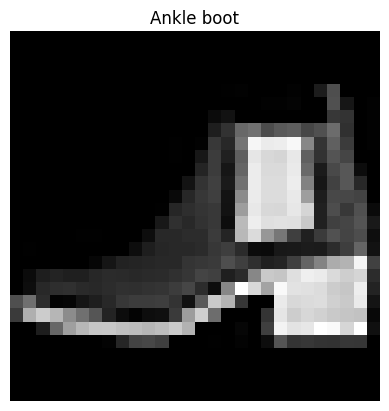

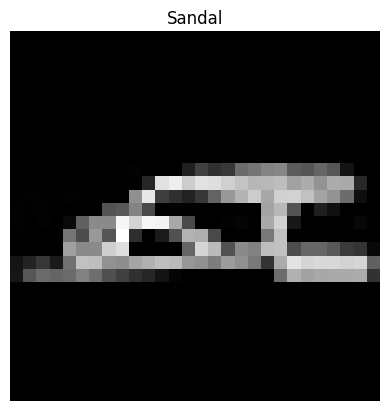

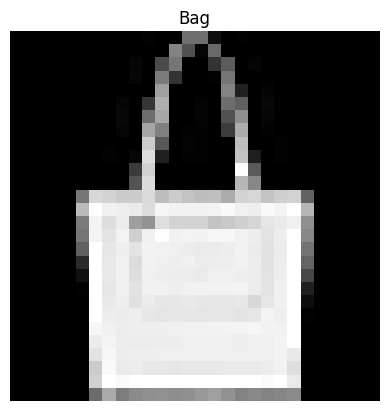

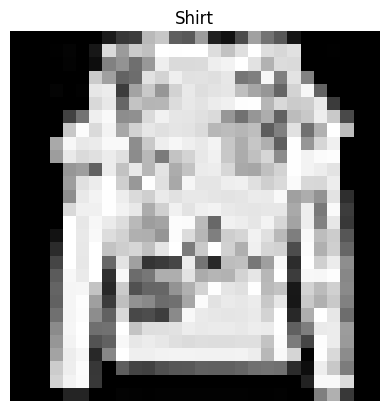

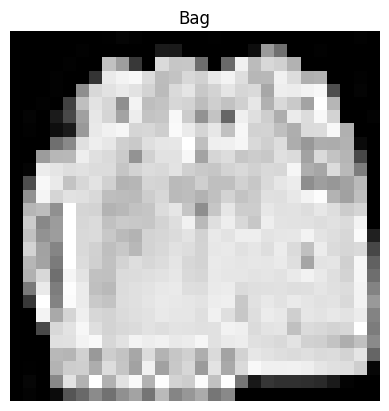

In [5]:
#lets have a look at some images
fashion_labels = [
    'T-shirt/top', 
    'Trouser', 
    'Pullover', 
    'Dress', 
    'Coat', 
    'Sandal', 
    'Shirt', 
    'Sneaker', 
    'Bag', 
    'Ankle boot'
]

def show_image(img_tensor, label):
    # img_tensor is [1, 28, 28] shape from FashionMNIST
    # convert to (28, 28) for plotting
    img_np = img_tensor.numpy().squeeze()
    plt.imshow(img_np, cmap='gray')
    plt.title(fashion_labels[label])
    plt.axis('off')
    plt.show()

#lets look at 5 random samples
for _ in range(5):
    idx = random.randint(0, len(train_dataset) - 1)
    img, label = train_dataset[idx]
    show_image(img, label)

To train a model we flatten the 28x28 images to a vector of raw pixels 

In [6]:
def dataset_to_numpy_1d(dataset, max_samples=None):
    """
    Convert a PyTorch dataset of (image, label) pairs
    to (X, y) NumPy arrays.
    - X.shape = (N, 784)
    - y.shape = (N,)
    """
    X_list = []
    y_list = []
    count = 0
    
    for img, label in dataset:
        # img: [1, 28, 28], convert to [28, 28]
        img_np = img.numpy().squeeze()
        # Flatten to 784
        img_flat = img_np.flatten()
        
        X_list.append(img_flat)
        y_list.append(label)
        
        count += 1
        if max_samples is not None and count >= max_samples:
            break
    
    X = np.stack(X_list, axis=0)
    y = np.array(y_list)
    return X, y

In [7]:
X_train_np, y_train_np = dataset_to_numpy_1d(train_dataset)
X_test_np, y_test_np = dataset_to_numpy_1d(test_dataset, max_samples=None)

In [8]:
print("Train:", X_train_np.shape, y_train_np.shape)
print("Test: ", X_test_np.shape,  y_test_np.shape)  

Train: (60000, 784) (60000,)
Test:  (10000, 784) (10000,)


In [9]:
def dataset_to_numpy_2d(dataset, max_samples=None):
    """
    Convert a PyTorch dataset of (image, label) pairs
    to (X, y) NumPy arrays.
    - X will be of shape (N, 28, 28)
    - y will be of shape (N,)
    """
    X_list = []
    y_list = []
    count = 0
    
    for img, label in dataset:
        # img is a 1x28x28 tensor, scale is [0..1]
        img_np = img.numpy().squeeze()  # shape (28,28)
        X_list.append(img_np)
        y_list.append(label)
        count += 1
        if max_samples is not None and count >= max_samples:
            break
    
    X = np.stack(X_list, axis=0)
    y = np.array(y_list)
    return X, y

In [10]:
X_train, y_train = dataset_to_numpy_2d(train_dataset)
X_test, y_test = dataset_to_numpy_2d(test_dataset, max_samples=None)

In [11]:
print("Train:", X_train.shape, y_train.shape)
print("Test: ", X_test.shape,  y_test.shape)  

Train: (60000, 28, 28) (60000,)
Test:  (10000, 28, 28) (10000,)


In [12]:
#helper function for confusion matrices later 
def plot_confusion_matrix(y_true, y_pred, classes, title="Confusion Matrix"):
    """
    Plots a confusion matrix using seaborn's heatmap.
    
    Args:
        y_true (array-like): True labels.
        y_pred (array-like): Predicted labels.
        classes (list of str): Class names for the axes.
        title (str): Title for the plot.
    """
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm, 
        annot=True,       # show numbers in each cell
        fmt='d',          # integer format
        cmap='Blues',     # color map
        xticklabels=classes, 
        yticklabels=classes
    )
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

## Grayscale Histograms - simple feature representation: 
(as this dataset constists of grayscale images)

lets visualize some of them 

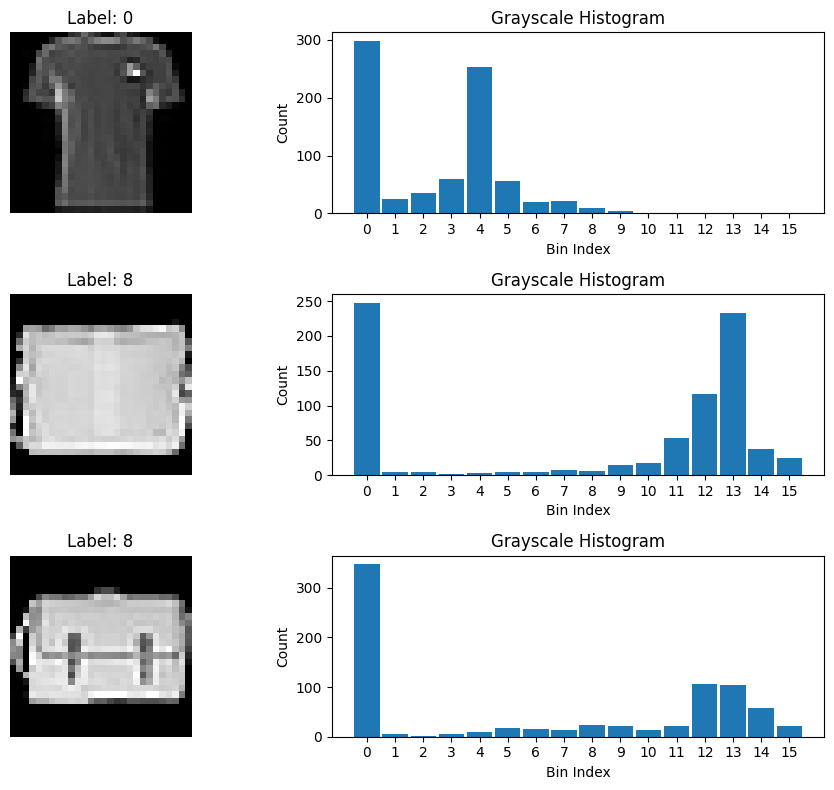

In [ ]:
import random
import matplotlib.pyplot as plt

def compute_grayscale_histogram_single(img_np, bins=16):
    """
    Compute a single grayscale histogram for one image.
    img_np: shape (H, W) with pixel values in [0..1]
    bins: number of histogram bins

    returns: (hist, bin_edges)
    """
    # Scale to [0,255] if your data is [0,1]
    img_8u = (img_np * 255).astype("uint8")
    hist, bin_edges = np.histogram(img_8u, bins=bins, range=(0, 256))
    return hist, bin_edges

# Let's say X_train is of shape (N, 28, 28), and y_train has labels
num_samples_to_plot = 3

fig, axes = plt.subplots(num_samples_to_plot, 2, figsize=(10, 8))

for i in range(num_samples_to_plot):
    # Pick a random index
    idx = random.randint(0, X_train.shape[0] - 1)
    # Grab the 2D image (shape = 28x28)
    img_2d = X_train[idx]  
    label = y_train[idx]

    # Compute the histogram for this single image
    hist, bin_edges = compute_grayscale_histogram_single(img_2d, bins=16)

    # Show the image
    ax_img = axes[i, 0]
    # img_2d is already (28,28), so it's safe for imshow
    ax_img.imshow(img_2d, cmap='gray')
    ax_img.set_title(f"Label: {label}")
    ax_img.axis("off")

    # Show the histogram
    ax_hist = axes[i, 1]
    ax_hist.bar(range(len(hist)), hist, width=0.9)
    ax_hist.set_title("Grayscale Histogram")
    ax_hist.set_xlabel("Bin Index")
    ax_hist.set_ylabel("Count")
    ax_hist.set_xticks(range(len(hist)))

plt.tight_layout()
plt.show()


In [ ]:
start_time = time.time()

X_train_hist = []
for img in X_train:
    hist, _ = compute_grayscale_histogram_single(img, bins=16)
    # Optionally normalize the histogram so total count is 1
    hist = hist.astype(np.float32)
    hist /= (hist.sum() + 1e-7)
    X_train_hist.append(hist)
X_test_hist = []
for img in X_test:
    hist, _ = compute_grayscale_histogram_single(img, bins=16)
    hist = hist.astype(np.float32)
    hist /= (hist.sum() + 1e-7)
    X_test_hist.append(hist)

feat_time_hist = time.time() - start_time

print(f"[Grayscale Histograms] Feature extraction time: {feat_time_hist:.3f} sec")

[Grayscale Histograms] Feature extraction time: 3.598 sec


In [ ]:
X_train_hist = np.array(X_train_hist, dtype=np.float32)
X_test_hist = np.array(X_test_hist, dtype=np.float32)

In [ ]:
print("Training hist shape:", X_train_hist.shape)  
print("Test hist shape:", X_test_hist.shape)    

Training hist shape: (60000, 16)
Test hist shape: (10000, 16)


### SVM
- tune hyperparameters with grid-search

In [ ]:
param_grid_svm = {
    'C':      [ 1, 10],
    'kernel': ['rbf'],
    'gamma': [0.1, 1]
}

svm = SVC()

grid_svm = GridSearchCV(
    estimator=svm,
    param_grid=param_grid_svm,
    scoring='accuracy',
    cv=3,              # 3-fold cross-validation
    verbose=1,         # print intermediate results
    n_jobs=-1          # use all available CPU cores
)

start_grid_svm = time.time()
grid_svm.fit(X_train_hist, y_train)
grid_svm_time = time.time() - start_grid_svm
print(f"GridSearchCV for SVM took {grid_svm_time:.2f} seconds")

print("Best SVM params:", grid_svm.best_params_)
print("Best cross-val accuracy:", grid_svm.best_score_)

best_svm = grid_svm.best_estimator_

Fitting 3 folds for each of 4 candidates, totalling 12 fits
GridSearchCV for SVM took 529.54 seconds
Best SVM params: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Best cross-val accuracy: 0.4380833333333333


In [ ]:
start_svm_train = time.time()
best_svm.fit(X_train_hist, y_train)
svm_train_time = time.time() - start_svm_train
print(f"Best SVM final train time: {svm_train_time:.2f} seconds")

Best SVM final train time: 103.67 seconds


In [ ]:
start_svm_test = time.time()
y_pred_svm = best_svm.predict(X_test_hist)
svm_test_time = time.time() - start_svm_test
print(f"Best SVM test time: {svm_test_time:.2f} seconds")

Best SVM test time: 34.56 seconds


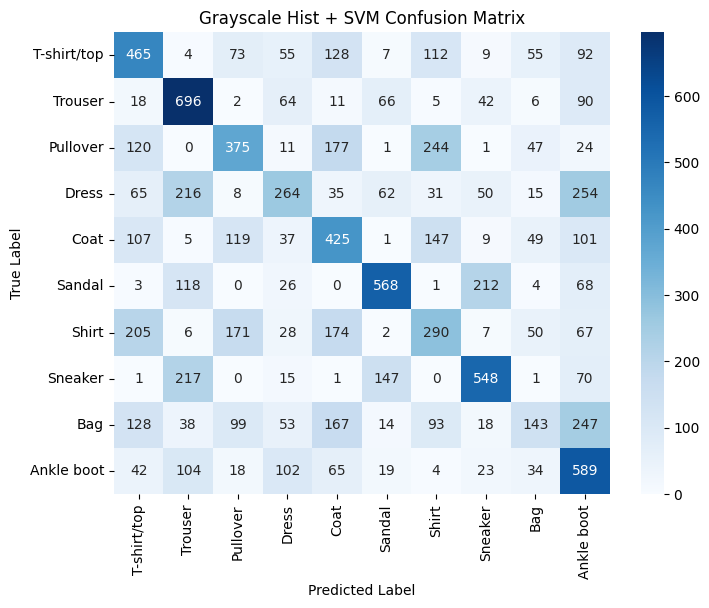

Grayscale Hist + SVM Accuracy: 0.4363
              precision    recall  f1-score   support

 T-shirt/top       0.40      0.47      0.43      1000
     Trouser       0.50      0.70      0.58      1000
    Pullover       0.43      0.38      0.40      1000
       Dress       0.40      0.26      0.32      1000
        Coat       0.36      0.42      0.39      1000
      Sandal       0.64      0.57      0.60      1000
       Shirt       0.31      0.29      0.30      1000
     Sneaker       0.60      0.55      0.57      1000
         Bag       0.35      0.14      0.20      1000
  Ankle boot       0.37      0.59      0.45      1000

    accuracy                           0.44     10000
   macro avg       0.44      0.44      0.43     10000
weighted avg       0.44      0.44      0.43     10000



In [ ]:
plot_confusion_matrix(y_test, y_pred_svm, fashion_labels, title="Grayscale Hist + SVM Confusion Matrix")

acc_svm = accuracy_score(y_test, y_pred_svm)
print("Grayscale Hist + SVM Accuracy:", acc_svm)

print(classification_report(y_test, y_pred_svm, target_names=fashion_labels))

### KNN 

In [ ]:
knn_param_grid = {
    'n_neighbors': [3, 5, 7],
    'weights':     ['uniform', 'distance']
}
knn = KNeighborsClassifier()

grid_knn = GridSearchCV(
    estimator=knn,
    param_grid=knn_param_grid,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1
)

In [ ]:
start_grid_knn = time.time()
grid_knn.fit(X_train_hist, y_train)
grid_knn_time = time.time() - start_grid_knn
print(f"GridSearchCV for kNN took {grid_knn_time:.2f} seconds")


print("Best kNN params:", grid_knn.best_params_)
print("Best cross-val accuracy:", grid_knn.best_score_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
GridSearchCV for kNN took 34.41 seconds
Best kNN params: {'n_neighbors': 7, 'weights': 'distance'}
Best cross-val accuracy: 0.43934999999999996


In [ ]:
best_knn = grid_knn.best_estimator_
start_knn_train = time.time()
best_knn.fit(X_train_hist, y_train)
knn_train_time = time.time() - start_knn_train
print(f"Best kNN final train time: {knn_train_time:.2f} seconds")

Best kNN final train time: 0.02 seconds


In [ ]:
start_knn_test = time.time()
y_pred_knn = best_knn.predict(X_test_hist)
knn_test_time = time.time() - start_knn_test
print(f"Best kNN test time: {knn_test_time:.2f} seconds")

Best kNN test time: 0.95 seconds


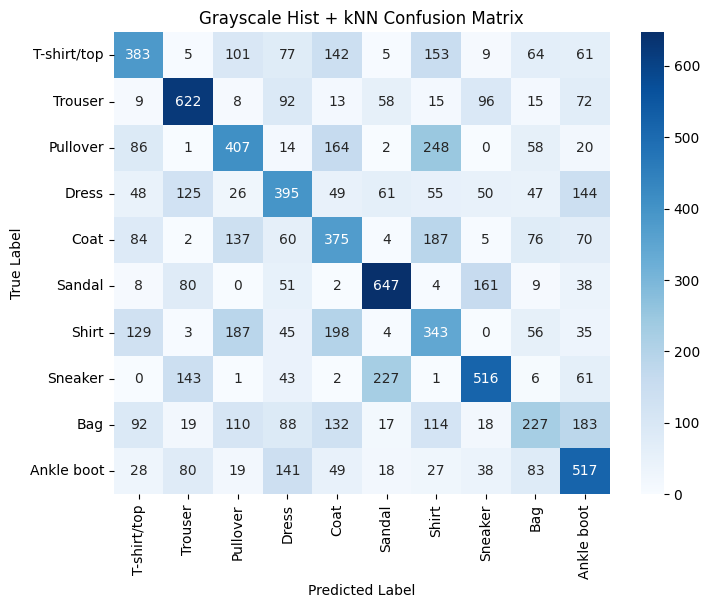

Grayscale Hist + kNN Accuracy: 0.4432
              precision    recall  f1-score   support

 T-shirt/top       0.44      0.38      0.41      1000
     Trouser       0.58      0.62      0.60      1000
    Pullover       0.41      0.41      0.41      1000
       Dress       0.39      0.40      0.39      1000
        Coat       0.33      0.38      0.35      1000
      Sandal       0.62      0.65      0.63      1000
       Shirt       0.30      0.34      0.32      1000
     Sneaker       0.58      0.52      0.55      1000
         Bag       0.35      0.23      0.28      1000
  Ankle boot       0.43      0.52      0.47      1000

    accuracy                           0.44     10000
   macro avg       0.44      0.44      0.44     10000
weighted avg       0.44      0.44      0.44     10000



In [ ]:
plot_confusion_matrix(y_test, y_pred_knn, fashion_labels, title="Grayscale Hist + kNN Confusion Matrix")

acc_knn = accuracy_score(y_test, y_pred_knn)
print("Grayscale Hist + kNN Accuracy:", acc_knn)

print(classification_report(y_test, y_pred_knn, target_names=fashion_labels))

In [ ]:
print("\n=== RUNTIME SUMMARY ===")
print(f"Feature extraction time: {feat_time_hist:.2f}s")
print(f"SVM GridSearch time:     {grid_svm_time:.2f}s")
print(f"SVM final train time:    {svm_train_time:.2f}s")
print(f"SVM test time:           {svm_test_time:.2f}s")
print(f"kNN GridSearch time:     {grid_knn_time:.2f}s")
print(f"kNN final train time:    {knn_train_time:.2f}s")
print(f"kNN test time:           {knn_test_time:.2f}s")

print("\n=== ACCURACY SUMMARY ===")
print(f"Best SVM test accuracy:  {acc_svm:.3f} with params {grid_svm.best_params_}")
print(f"Best kNN test accuracy:  {acc_knn:.3f} with params {grid_knn.best_params_}")


=== RUNTIME SUMMARY ===
Feature extraction time: 3.60s
SVM GridSearch time:     529.54s
SVM final train time:    103.67s
SVM test time:           34.56s
kNN GridSearch time:     34.41s
kNN final train time:    0.02s
kNN test time:           0.95s

=== ACCURACY SUMMARY ===
Best SVM test accuracy:  0.436 with params {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Best kNN test accuracy:  0.443 with params {'n_neighbors': 7, 'weights': 'distance'}


## HOG feature extraction
- SIFT might not get a lot of key points as the images are very small
- color histograms dont really make sense either as these are black and white images 

In [ ]:
from skimage.feature import hog

In [ ]:
def compute_hog_features(images_np, 
                         orientations=9, 
                         pixels_per_cell=(8,8),
                         cells_per_block=(1,1)):
    """
    images_np: shape (N, H, W) in [0..1]
    returns: 2D array of shape (N, feature_dim) with HOG descriptors
    """
    feature_list = []
    for img in images_np:
        hog_desc = hog(
            img,
            orientations=orientations,
            pixels_per_cell=pixels_per_cell,
            cells_per_block=cells_per_block,
            block_norm='L2-Hys',
            visualize=False
        )
        feature_list.append(hog_desc)
    return np.array(feature_list, dtype=np.float32)

start_feat = time.time()
X_train_hog = compute_hog_features(X_train)
X_test_hog  = compute_hog_features(X_test)
feat_time = time.time() - start_feat
print(f"HOG feature extraction time: {feat_time:.2f} seconds")

print("X_train_hog shape:", X_train_hog.shape)
print("X_test_hog shape:",  X_test_hog.shape)

HOG feature extraction time: 10.27 seconds
X_train_hog shape: (60000, 81)
X_test_hog shape: (10000, 81)


### SVM

In [ ]:
svm_param_grid = {
    'C':      [ 0.1, 1, 10],
    'kernel': ['rbf', 'linear'],
    'gamma': [0.1, 1]
}

svm = SVC()

grid_svm = GridSearchCV(
    estimator=svm,
    param_grid=svm_param_grid,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1
)

start_grid_svm = time.time()
grid_svm.fit(X_train_hog, y_train)
grid_svm_time = time.time() - start_grid_svm
print(f"SVM GridSearch took {grid_svm_time:.2f} seconds")

print("Best SVM params:", grid_svm.best_params_)
print("Best cross-val accuracy:", grid_svm.best_score_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
SVM GridSearch took 1061.62 seconds
Best SVM params: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
Best cross-val accuracy: 0.8304166666666667


In [ ]:
best_svm = grid_svm.best_estimator_

start_svm_train = time.time()
best_svm.fit(X_train_hog, y_train)
svm_train_time = time.time() - start_svm_train
print(f"Best SVM final train time: {svm_train_time:.2f} seconds")

Best SVM final train time: 209.95 seconds


In [ ]:
start_svm_test = time.time()
y_pred_svm = best_svm.predict(X_test_hog)
svm_test_time = time.time() - start_svm_test
print(f"Best SVM test time: {svm_test_time:.2f} seconds")

Best SVM test time: 29.55 seconds


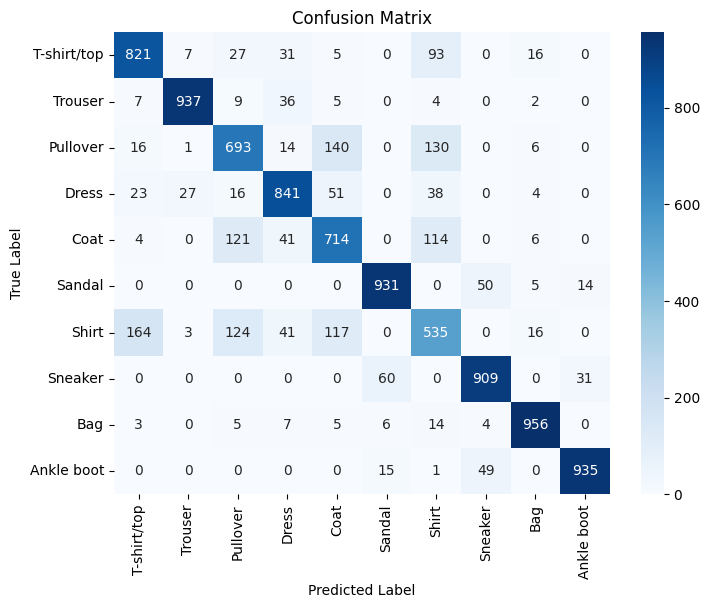

HOG+SVM Accuracy: 0.8272
Classification Report (SVM):
              precision    recall  f1-score   support

 T-shirt/top       0.79      0.82      0.81      1000
     Trouser       0.96      0.94      0.95      1000
    Pullover       0.70      0.69      0.69      1000
       Dress       0.83      0.84      0.84      1000
        Coat       0.69      0.71      0.70      1000
      Sandal       0.92      0.93      0.93      1000
       Shirt       0.58      0.54      0.55      1000
     Sneaker       0.90      0.91      0.90      1000
         Bag       0.95      0.96      0.95      1000
  Ankle boot       0.95      0.94      0.94      1000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



In [ ]:
plot_confusion_matrix(y_test, y_pred_svm, fashion_labels)

acc_svm = accuracy_score(y_test, y_pred_svm)
print("HOG+SVM Accuracy:", acc_svm)

print("Classification Report (SVM):")
print(classification_report(y_test, y_pred_svm, target_names=fashion_labels))

### KNN

In [ ]:
knn_param_grid = {
    'n_neighbors': [3, 5, 7],
    'weights':     ['uniform', 'distance']
}

knn = KNeighborsClassifier()

grid_knn = GridSearchCV(
    estimator=knn,
    param_grid=knn_param_grid,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1
)

start_grid_knn = time.time()
grid_knn.fit(X_train_hog, y_train)
grid_knn_time = time.time() - start_grid_knn
print(f"kNN GridSearch took {grid_knn_time:.2f} seconds")

print("Best kNN params:", grid_knn.best_params_)
print("Best cross-val accuracy:", grid_knn.best_score_)


Fitting 3 folds for each of 6 candidates, totalling 18 fits
kNN GridSearch took 22.47 seconds
Best kNN params: {'n_neighbors': 7, 'weights': 'uniform'}
Best cross-val accuracy: 0.7761833333333333


In [ ]:
best_knn = grid_knn.best_estimator_

start_knn_train = time.time()
best_knn.fit(X_train_hog, y_train)
knn_train_time = time.time() - start_knn_train
print(f"Best kNN final train time: {knn_train_time:.2f} seconds")

Best kNN final train time: 0.01 seconds


In [ ]:
start_knn_test = time.time()
y_pred_knn = best_knn.predict(X_test_hog)
knn_test_time = time.time() - start_knn_test
print(f"Best kNN test time: {knn_test_time:.2f} seconds")

Best kNN test time: 1.36 seconds


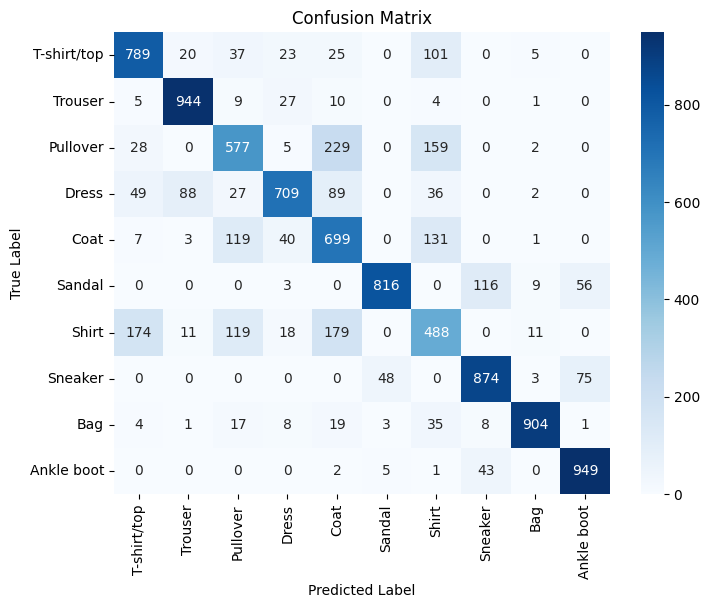

HOG + kNN Accuracy: 0.7749
Classification Report (kNN):
              precision    recall  f1-score   support

 T-shirt/top       0.75      0.79      0.77      1000
     Trouser       0.88      0.94      0.91      1000
    Pullover       0.64      0.58      0.61      1000
       Dress       0.85      0.71      0.77      1000
        Coat       0.56      0.70      0.62      1000
      Sandal       0.94      0.82      0.87      1000
       Shirt       0.51      0.49      0.50      1000
     Sneaker       0.84      0.87      0.86      1000
         Bag       0.96      0.90      0.93      1000
  Ankle boot       0.88      0.95      0.91      1000

    accuracy                           0.77     10000
   macro avg       0.78      0.77      0.78     10000
weighted avg       0.78      0.77      0.78     10000



In [ ]:
plot_confusion_matrix(y_test, y_pred_knn, fashion_labels)

acc_knn = accuracy_score(y_test, y_pred_knn)
print("HOG + kNN Accuracy:", acc_knn)

print("Classification Report (kNN):")
print(classification_report(y_test, y_pred_knn, target_names=fashion_labels))

In [ ]:
print("\n=== RUNTIME SUMMARY ===")
print(f"HOG feature extraction time: {feat_time:.2f}s")
print(f"SVM GridSearch time:         {grid_svm_time:.2f}s")
print(f"SVM final train time:        {svm_train_time:.2f}s")
print(f"SVM test time:               {svm_test_time:.2f}s")
print(f"kNN GridSearch time:         {grid_knn_time:.2f}s")
print(f"kNN final train time:        {knn_train_time:.2f}s")
print(f"kNN test time:               {knn_test_time:.2f}s")

print("\n=== ACCURACY SUMMARY ===")
print(f"Best SVM test accuracy: {acc_svm:.3f} with {grid_svm.best_params_}")
print(f"Best kNN test accuracy: {acc_knn:.3f} with {grid_knn.best_params_}")


=== RUNTIME SUMMARY ===
HOG feature extraction time: 10.27s
SVM GridSearch time:         1061.62s
SVM final train time:        209.95s
SVM test time:               29.55s
kNN GridSearch time:         22.47s
kNN final train time:        0.01s
kNN test time:               1.36s

=== ACCURACY SUMMARY ===
Best SVM test accuracy: 0.827 with {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
Best kNN test accuracy: 0.775 with {'n_neighbors': 7, 'weights': 'uniform'}


## Fully connected NN

In [ ]:
import tensorflow as tf
from tensorflow import keras

standardize data with standard scaling before feeding it into the NN 


In [ ]:
mean = np.mean(X_train_np)
std = np.std(X_train_np)

X_train = (X_train_np - mean) / std
X_test = (X_test_np - mean) / std

as the fully connected nn expects 1d arrays, we will need to flatten our data 

In [ ]:
X_train = X_train.reshape((X_train.shape[0], 28 * 28))
X_test = X_test.reshape((X_test.shape[0], 28 * 28))

In [ ]:
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Input(shape=(28*28,)), #flattened image      
    layers.Dense(128, activation='relu'), #hidden layer with 128 units
    layers.Dense(64, activation='relu'), #hidden layer with 64 units
    layers.Dense(10, activation='softmax')  #output for 10 classes
])

model.compile(
    loss='sparse_categorical_crossentropy', #multiclass classification
    optimizer='sgd', #stochastic gradien descent
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,386 (427.29 KB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#train model now 
history = model.fit(
    X_train, y_train_np,
    epochs=15,             
    batch_size=64,        
    validation_split=0.1  
)

Epoch 1/15
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6979 - loss: 0.8999 - val_accuracy: 0.8198 - val_loss: 0.4832
Epoch 2/15
844/844 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8414 - loss: 0.4549 - val_accuracy: 0.8413 - val_loss: 0.4260
Epoch 3/15
844/844 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8544 - loss: 0.4086 - val_accuracy: 0.8480 - val_loss: 0.4102
Epoch 4/15
844/844 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8609 - loss: 0.3833 - val_accuracy: 0.8562 - val_loss: 0.3887
Epoch 5/15
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8668 - loss: 0.3717 - val_accuracy: 0.8617 - val_loss: 0.3859
Epoch 6/15
844/844 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8758 - loss: 0.3497 - val_accuracy: 0.8645 - val_loss: 0.3687
Epoch 7/15
844/844 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8792 - loss: 0.3387 - val_accuracy: 0.8605 - val_loss: 0.3869
Epoch 8/15
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8820 - loss: 0.3313 - val_accuracy: 0.

In [ ]:
#predict on test set
y_probs = model.predict(X_test)          
y_pred  = np.argmax(y_probs, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step


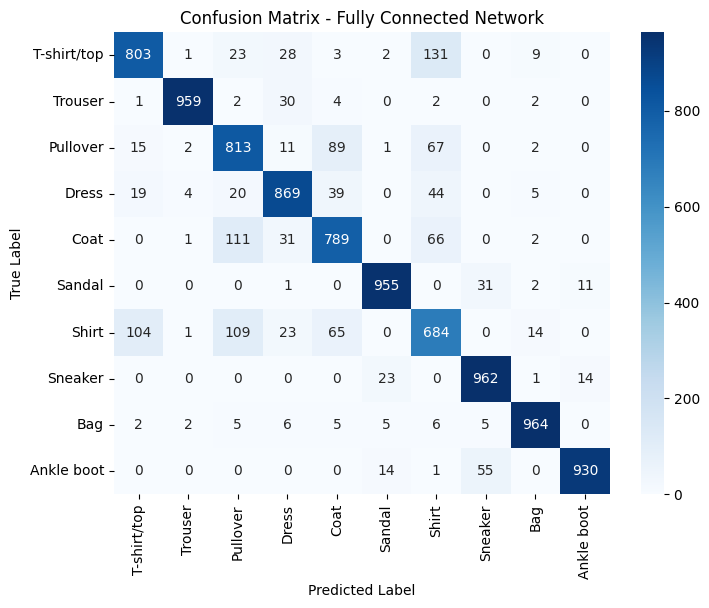

Test Accuracy: 0.8728
Classification Report:
               precision    recall  f1-score   support

 T-shirt/top       0.85      0.80      0.83      1000
     Trouser       0.99      0.96      0.97      1000
    Pullover       0.75      0.81      0.78      1000
       Dress       0.87      0.87      0.87      1000
        Coat       0.79      0.79      0.79      1000
      Sandal       0.95      0.95      0.95      1000
       Shirt       0.68      0.68      0.68      1000
     Sneaker       0.91      0.96      0.94      1000
         Bag       0.96      0.96      0.96      1000
  Ankle boot       0.97      0.93      0.95      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



In [ ]:
plot_confusion_matrix(
    y_true=y_test_np, 
    y_pred=y_pred, 
    classes=fashion_labels, 
    title="Confusion Matrix - Fully Connected Network"
)

loss, acc = model.evaluate(X_test, y_test_np, verbose=0)
print(f"Test Accuracy: {acc:.4f}")

print("Classification Report:\n", classification_report(y_test_np, y_pred, target_names=fashion_labels))


## CNN

here we need to do some more preprocessing as the CNN expects a 4D tensor (N, height, width, channels)
as we only have grayscale images, channels = 1 

In [ ]:
X_train = X_train.reshape((X_train_np.shape[0], 28, 28, 1))
X_test = X_test.reshape((X_test_np.shape[0], 28, 28, 1))

print("Reshaped X_train shape:", X_train.shape)

Reshaped X_train shape: (60000, 28, 28, 1)


In [ ]:
#scale to [0,1]
X_train = X_train.astype("float32") / 255.0
X_test = X_test.astype("float32") / 255.0


In [ ]:
model_cnn = keras.Sequential([
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    #2nd layer
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')  #output for 10 classes
])

model_cnn.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model_cnn.summary()

C:\Users\timgr\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,930 (476.29 KB)

 Trainable params: 121,930 (476.29 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
start_train = time.time()
history = model_cnn.fit(
    X_train, y_train_np,
    epochs=10,         
    batch_size=64,    
    validation_split=0.1,  
    verbose=1
)
train_time = time.time() - start_train
print(f"\nTraining completed in {train_time:.2f} seconds.")

Epoch 1/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8101 - loss: 0.5092 - val_accuracy: 0.8217 - val_loss: 0.4776
Epoch 2/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8205 - loss: 0.4809 - val_accuracy: 0.8252 - val_loss: 0.4766
Epoch 3/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8285 - loss: 0.4686 - val_accuracy: 0.8330 - val_loss: 0.4520
Epoch 4/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.8357 - loss: 0.4504 - val_accuracy: 0.8372 - val_loss: 0.4362
Epoch 5/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.8460 - loss: 0.4234 - val_accuracy: 0.8373 - val_loss: 0.4308
Epoch 6/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.8480 - loss: 0.4146 - val_accuracy: 0.8350 - val_loss: 0.4503
Epoch 7/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.8496 - loss: 0.4101 - val_accuracy: 0.8457 - val_loss: 0.4135
Epoch 8/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.8546 - loss: 0.3976 - val_accur

In [ ]:
start_test = time.time()
loss, accuracy = model_cnn.evaluate(X_test, y_test_np, verbose=0)
test_time = time.time() - start_test
print(f"Testing completed in {test_time:.2f} seconds.")

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Testing completed in 0.78 seconds.
Test Loss: 0.4169738292694092
Test Accuracy: 0.848800003528595


In [ ]:
y_pred_probs = model_cnn.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


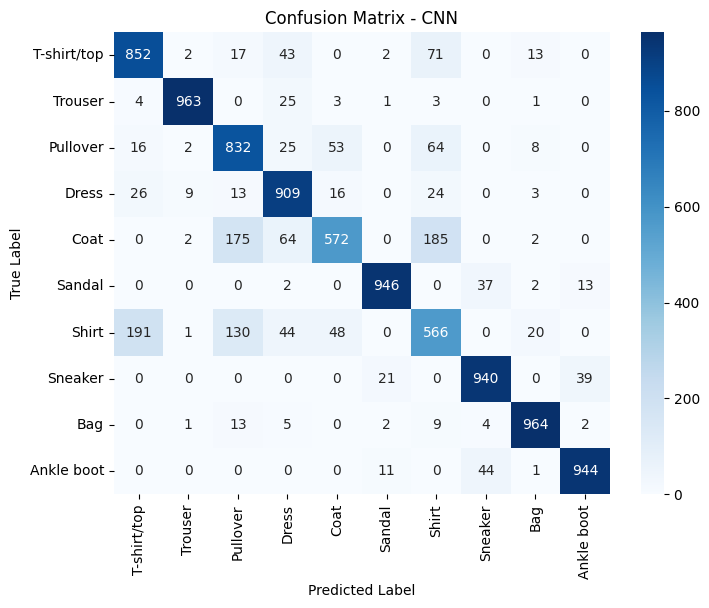

Test accuracy: 0.8488
Classification Report (CNN):
              precision    recall  f1-score   support

 T-shirt/top       0.78      0.85      0.82      1000
     Trouser       0.98      0.96      0.97      1000
    Pullover       0.71      0.83      0.76      1000
       Dress       0.81      0.91      0.86      1000
        Coat       0.83      0.57      0.68      1000
      Sandal       0.96      0.95      0.95      1000
       Shirt       0.61      0.57      0.59      1000
     Sneaker       0.92      0.94      0.93      1000
         Bag       0.95      0.96      0.96      1000
  Ankle boot       0.95      0.94      0.94      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



In [ ]:
plot_confusion_matrix(
    y_true=y_test_np, 
    y_pred=y_pred, 
    classes=fashion_labels, 
    title="Confusion Matrix - CNN"
)


test_loss, test_acc = model_cnn.evaluate(X_test, y_test_np, verbose=0)
print(f"Test accuracy: {test_acc:.4f}")

print("Classification Report (CNN):")
print(classification_report(y_test_np, y_pred, target_names=fashion_labels))

## ResNet 

we built a small ResNet ourselves here as we have a very small input

In [13]:
X_train = np.expand_dims(X_train, axis=-1)  
X_test  = np.expand_dims(X_test, axis=-1)  

print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape,   "y_test shape:", y_test.shape)

X_train shape: (60000, 28, 28, 1) y_train shape: (60000,)
X_test shape: (10000, 28, 28, 1) y_test shape: (10000,)


now we build a residual block 
- Convolution -> BatchNorm -> Relu
- another convolution -> BatchNorm
- add the original input
- final relu 

In [14]:
def residual_block(x, filters):
    """
    A simple residual block:
      - 2x conv3x3 + BN
      - Skip connection
      - ReLU at the end
    x is a Keras tensor
    filters: number of channels for conv
    """
    shortcut = x  # for skip connection

    # 1st conv
    x = layers.Conv2D(filters, (3,3), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # 2nd conv
    x = layers.Conv2D(filters, (3,3), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    # Skip connection: add input
    x = layers.Add()([shortcut, x])
    x = layers.ReLU()(x)
    return x

In [15]:
def build_small_resnet(input_shape=(28,28,1), num_classes=10):
    inputs = layers.Input(shape=input_shape)

    # Initial conv
    x = layers.Conv2D(32, (3,3), padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    #residual blocks with 32 filters
    x = residual_block(x, 32)
    x = residual_block(x, 32)

    # Downsample (optional). For 28x28, let's do a small pool to reduce spatial dim:
    #x = layers.MaxPooling2D(pool_size=(2,2))(x)  # now 14x14

    #Increase filters to 64
    x = layers.Conv2D(64, (1,1), strides=1, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    #Residual blocks with 64 filters
    x = residual_block(x, 64)
    x = residual_block(x, 64)

    #Now global average pool from 14x14 to 1x1
    x = layers.GlobalAveragePooling2D()(x)  # shape (None, 64)

    #Optionally add a dense layer
    x = layers.Dense(64, activation='relu')(x)
    #Output layer
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs, name="MiniResNet")
    return model


model_resnet = build_small_resnet(input_shape=(28,28,1), num_classes=10)
model_resnet.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model_resnet.summary()


Model: "MiniResNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 28, 28,    │        288 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 28, 28,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 28, 28,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 28, 28,    │      9,216 │ re_lu[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 28, 28,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 28,    │      9,216 │ re_lu_1[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 28, 28,    │          0 │ re_lu[0][0],      │
│                     │ 32)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 28, 28,    │          0 │ add[0][0]         │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 28, 28,    │      9,216 │ re_lu_2[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 28, 28,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 28, 28,    │      9,216 │ re_lu_3[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        128 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 28, 28,    │          0 │ re_lu_2[0][0],  

 Total params: 193,386 (755.41 KB)

 Trainable params: 192,426 (751.66 KB)

 Non-trainable params: 960 (3.75 KB)

In [17]:
start_train = time.time()
history = model_resnet.fit(
    X_train, y_train,
    epochs=5,            
    batch_size=64,
    validation_split=0.1
)
train_time = time.time() - start_train
print(f"Training time: {train_time:.2f} s")

Epoch 1/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 325s 385ms/step - accuracy: 0.7762 - loss: 0.6310 - val_accuracy: 0.7222 - val_loss: 0.7705
Epoch 2/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 298s 353ms/step - accuracy: 0.8681 - loss: 0.3634 - val_accuracy: 0.7040 - val_loss: 1.0060
Epoch 3/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 291s 345ms/step - accuracy: 0.8933 - loss: 0.2986 - val_accuracy: 0.8675 - val_loss: 0.3865
Epoch 4/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 300s 355ms/step - accuracy: 0.9052 - loss: 0.2612 - val_accuracy: 0.8817 - val_loss: 0.3285
Epoch 5/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 294s 349ms/step - accuracy: 0.9122 - loss: 0.2424 - val_accuracy: 0.8780 - val_loss: 0.3358
Training time: 1508.10 s


In [18]:
start_test = time.time()
loss, accuracy = model_resnet.evaluate(X_test, y_test, verbose=0)
test_time = time.time() - start_test
print(f"Testing time: {test_time:.2f} s")
print("Test accuracy:", accuracy)

Testing time: 10.25 s
Test accuracy: 0.8684999942779541


313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step


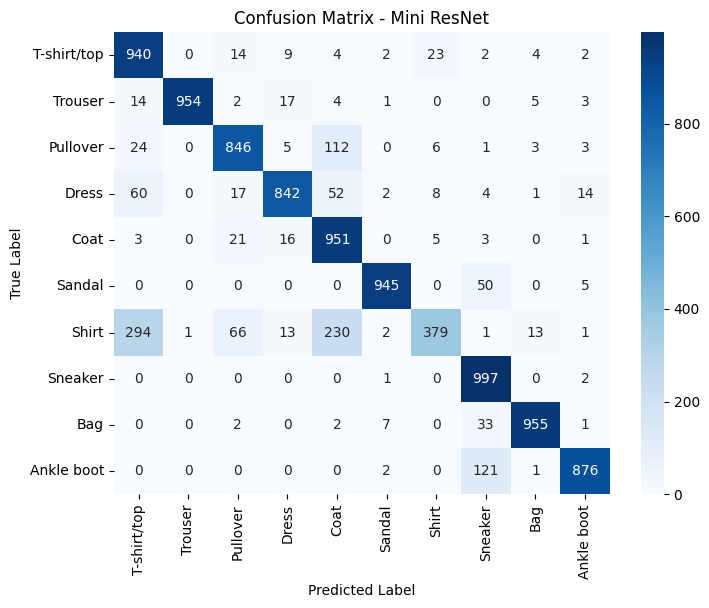

Classification Report (Mini ResNet):
              precision    recall  f1-score   support

 T-shirt/top       0.70      0.94      0.81      1000
     Trouser       1.00      0.95      0.98      1000
    Pullover       0.87      0.85      0.86      1000
       Dress       0.93      0.84      0.89      1000
        Coat       0.70      0.95      0.81      1000
      Sandal       0.98      0.94      0.96      1000
       Shirt       0.90      0.38      0.53      1000
     Sneaker       0.82      1.00      0.90      1000
         Bag       0.97      0.95      0.96      1000
  Ankle boot       0.96      0.88      0.92      1000

    accuracy                           0.87     10000
   macro avg       0.89      0.87      0.86     10000
weighted avg       0.89      0.87      0.86     10000



In [19]:
y_pred_probs = model_resnet.predict(X_test)      
y_pred = np.argmax(y_pred_probs, axis=1)

plot_confusion_matrix(y_test, y_pred, fashion_labels, title="Confusion Matrix - Mini ResNet")   

print("Classification Report (Mini ResNet):")
print(classification_report(y_test, y_pred, target_names=fashion_labels))